# DonorsChoose
## EDA and t-SNE on DonorsChoose dataset  

## 0. Importing Libraries 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle 

from tqdm import tqdm
import os

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

C:\Users\Pratik\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("\nTrain data shape : ", project_data.shape )
print('-'*50)
print("\nData attributes :", project_data.columns.values)


Train data shape :  (109248, 17)
--------------------------------------------------

Data attributes : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language                     ESL, Literacy   
1    History & Civics, Health & Sports  Civics & Government, Team Sports   
2                      Health & Sports    Health & Wellness, Team Sports   
3  Literacy & Language, Math & Science             Literacy, Mathematics   
4                       Math & Science                       Mathematics   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0  
3                                             4                    1  
4                                             1                    1

In [5]:
print("\nResource data shape : ", resource_data.shape)
print("\nResoure data attributes : ", resource_data.columns.values)


Resource data shape :  (1541272, 4)

Resoure data attributes :  ['id' 'description' 'quantity' 'price']


In [6]:
resource_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

## 1.2 Data Analysis 

Number of projects that are approved for funding 92706 ~ 84.86 % 
Number of projects that are NOT approved for funding 16542 ~ 15.14 % 


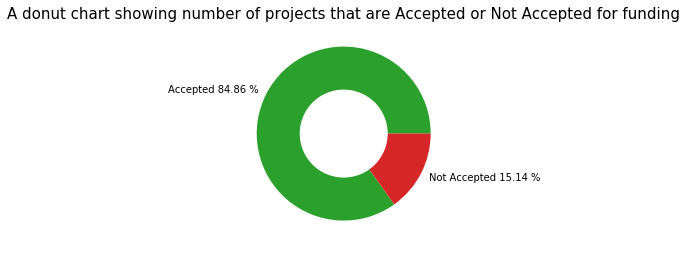

In [15]:
# No of class labels for each class - Approved (represented by 1) and Not Approved (represented by 0)
y_value_counts = project_data['project_is_approved'].value_counts()

approved = y_value_counts[1]
not_approved = y_value_counts[0]

approved_pct = round(approved/(approved + not_approved)*100, 2)
not_approved_pct = round(not_approved/(approved + not_approved)*100, 2)

# percentage of each class label 
print("Number of projects that are approved for funding {} ~ {} % ".format(approved, approved_pct))
print("Number of projects that are NOT approved for funding {} ~ {} % ".format(not_approved, not_approved_pct))

# Donut Chart 
# Source : https://python-graph-gallery.com/161-custom-matplotlib-donut-plot/ 
size_of_groups = [approved, not_approved]
 
# Create a pieplot
plt.pie(size_of_groups, labels = ['Accepted {} %'.format(approved_pct),'Not Accepted {} %'.format(not_approved_pct)], 
        colors = ['tab:green','tab:red'])

# add a circle at the center
my_circle = plt.Circle((0,0), 0.5, color = 'white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("A donut chart showing number of projects that are Accepted or Not Accepted for funding", fontsize = 15) 
plt.show()

### 1.2.1 Univariate Analysis: School State

In [8]:
temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if the data contain only 0 and 1, then the mean = percentage 
temp.columns = ['state_code', 'approval_rate']

# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['approval_rate'], inplace=True, ascending = False)
print("States with highest % approvals")
print(temp.head(5))
print('='*50)
print("States with lowest % approvals")
print(temp.tail(5))

States with highest % approvals
   state_code  approval_rate
8          DE       0.897959
28         ND       0.888112
47         WA       0.876178
35         OH       0.875152
30         NH       0.873563
States with lowest % approvals
   state_code  approval_rate
18         LA       0.831245
26         MT       0.816327
43         TX       0.813142
7          DC       0.802326
46         VT       0.800000


In [3]:
# Stacked Bar Plots
# Source: stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

def stack_plot(data, xtick, col2 = 'project_is_approved', col3 = 'Total'):
    ind = np.arange(data.shape[0]) #the x locations for the groups
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)
    
    plt.ylabel('Number of Projects', fontsize = 12)
    plt.title('Number of projects Approved vs Rejected', fontsize = 15)
    plt.xticks(ind, list(data[xtick].values), fontsize = 12, rotation = 40, ha = 'right')
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [4]:
def univariate_barplot(data, col1, col2='project_is_approved', top=False):
    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    temp['Total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Total':'count'})).reset_index()['Total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['Total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick = col1, col2 = col2, col3 = 'Total')
    
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

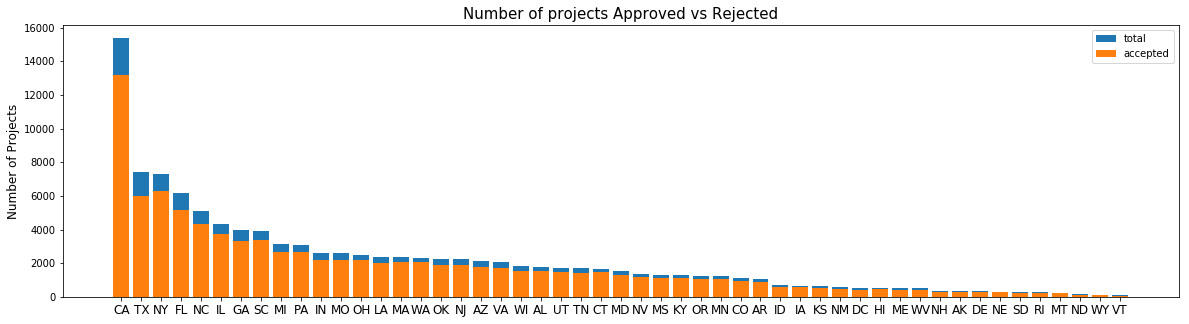

   school_state  project_is_approved  Total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  Total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [16]:
univariate_barplot(project_data, 'school_state', 'project_is_approved', False)

#### SUMMARY : 

* Highest number of project proposals are recived from the schools in the State of California, while lowest are from the State of Vermont.


* Every state has got project acceptance rate above 80% 


* The States of Delaware, North Dakota, Washington are among the States with highest project proposal acceptance rate, while states of Vermont, District of Columbia, Texas show some of the lowest project acceptance rate.


* States like Vermont, Wyoming, North Dakot has some of the lowest total proposals sent, this can be attributed to comparatively low population of these Satates in US and hence the number of schools is also less.  


* School state can be considered as one of the useful attribute in deciding whether the proposal is going to be approved or not. 

### 1.2.2 Univariate Analysis: teacher_prefix

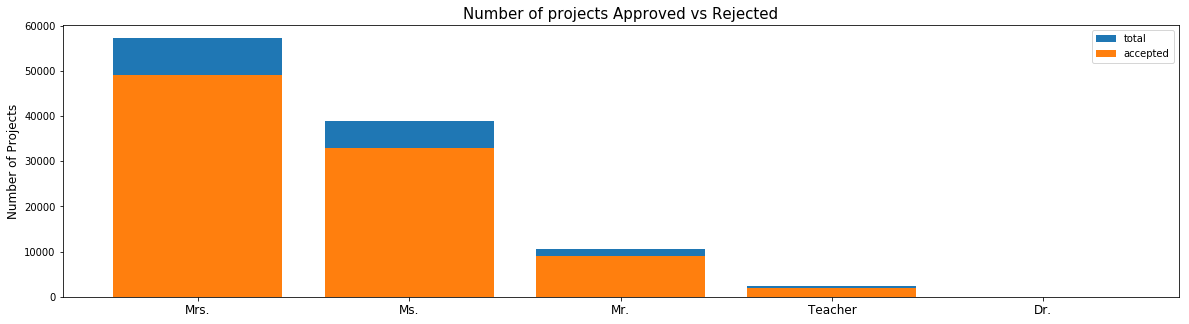

  teacher_prefix  project_is_approved  Total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  Total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [17]:
univariate_barplot(project_data, 'teacher_prefix', 'project_is_approved' , top = False)

#### SUMMARY: 

* Highest number of the project proposals are receivd from the teachers with the prefix 'Mrs' while lowest number of the proposals are received from the 'Dr'.


* Prefixes 'Mrs' and 'Ms' contitue the highest number project proposals received. Among these, the poposals received from 'Ms' alone is more 3 times the sum of the project proposal of remianing 3 categories - 'Mr', 'Teacher' and 'Dr'. 


* The project proposal acceptance rate is highest for the Missus ('Mrs') and is lowest for the Doctors ('Dr'). 

### 1.2.3 Univariate Analysis: project_grade_category

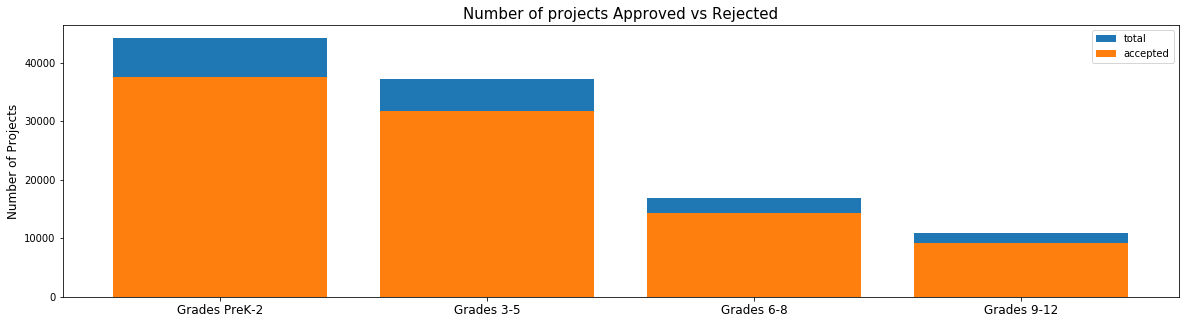

  project_grade_category  project_is_approved  Total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  Total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [18]:
univariate_barplot(project_data, 'project_grade_category', 'project_is_approved', top = False)

#### SUMMARY:
    
* Grades PreK-2 constitute highest number of project proposals while Grades 9-12 constitue the lowest.


* The project proposal acceptance rates is higest for the Grades 3-5 at about 85.4% and for rest of the grades, the difference is not much. 


### 1.2.4 Univariate Analysis: project_subject_categories

In [5]:
categories = list(project_data['project_subject_categories'].values)

# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string

cat_list = []
for i in categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j = j.replace('The', '') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ', '') # we are replacing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp += j.strip() + " " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&', '_') # we are replacing the '&' value into '_'
    cat_list.append(temp.strip())

In [6]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   
2    Health & Wellness, Team Sports   
3             Literacy, Mathematics   
4                       Mathematics   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories  
0               Literacy_Language  
1    History_Civics Health_Sports  
2                   Health_Sports  
3  Literacy_Language Math_Science  
4                    Math_Science

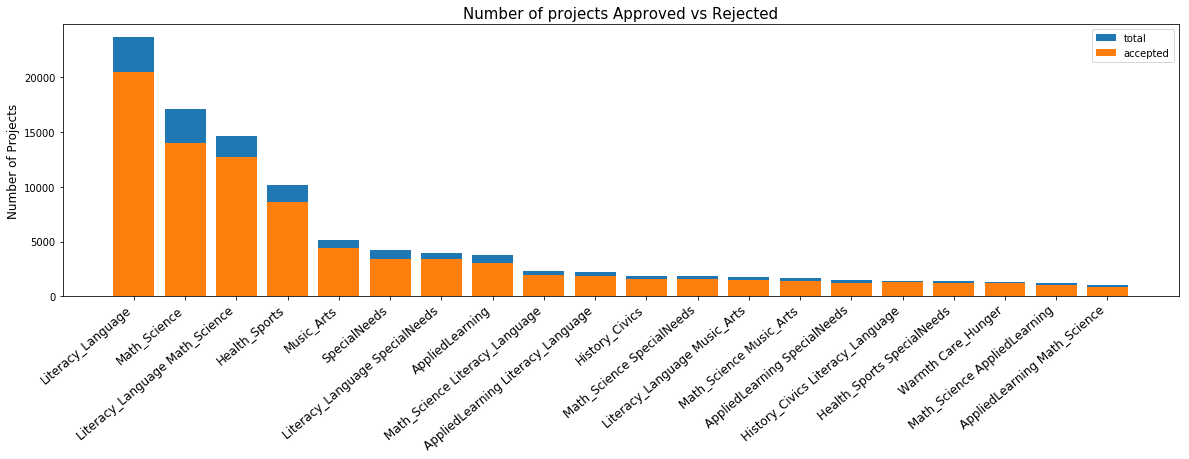

                  clean_categories  project_is_approved  Total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  Total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [24]:
univariate_barplot(project_data, 'clean_categories', 'project_is_approved', top = 20)

#### SUMMARY:

* Project category Literacy_Language has highest number of submissions and it's approval rate is pretty high. 


* History_Civics Warmth Care_Hunger and Music_Arts Warmth Care_Hunger are among some of the lowest submissions.


* Though total project submissions for Warmth Care_Hunger are low, but it has the higest percentage of project acceptance rate. 

In [7]:
# count of all the words in corpus (https://stackoverflow.com/a/22898595/4084039) 
from collections import Counter 
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

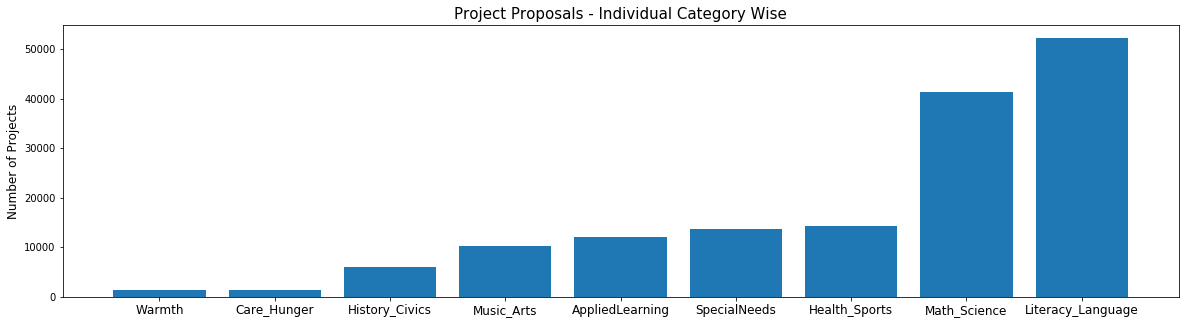

In [46]:
# dict sort by value (https://stackoverflow.com/a/613218/4084039)

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key = lambda kv: kv[1]))

plt.figure(figsize=(20,5))
ind = np.arange(len(sorted_cat_dict))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))


plt.ylabel('Number of Projects', fontsize = 12)
plt.title('Project Proposals - Individual Category Wise', fontsize = 15)
plt.xticks(ind, list(sorted_cat_dict.keys()), fontsize = 12)
plt.show()

#### SUMMARY:

* Highest number of the proposals received contain'Literacy_Language' as one of the subject categories. This is followed by Math_Science. 


* Warmth, Care_Hunger, History_civics constitute the lowest number of project proposal submissions. 

In [27]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [8]:
sub_categories = list(project_data['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_categories:
    temp =""
    for j in i.split(','):
        if 'The' in j.split():
            j = j.replace('The', '')
        j = j.replace(' ', '')
        temp += j.strip() + " "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [9]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

In [10]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories           clean_subcategories  
0               Literacy_Language                  ESL Literacy  
1    History_Civics Health_Sports  Civics_Government TeamSports  
2                   Health_Sports    Health_Wellness TeamSports  
3  Literacy_Language Math_Science          Literacy Mathematics  
4                    Math_Science                   Mathematics

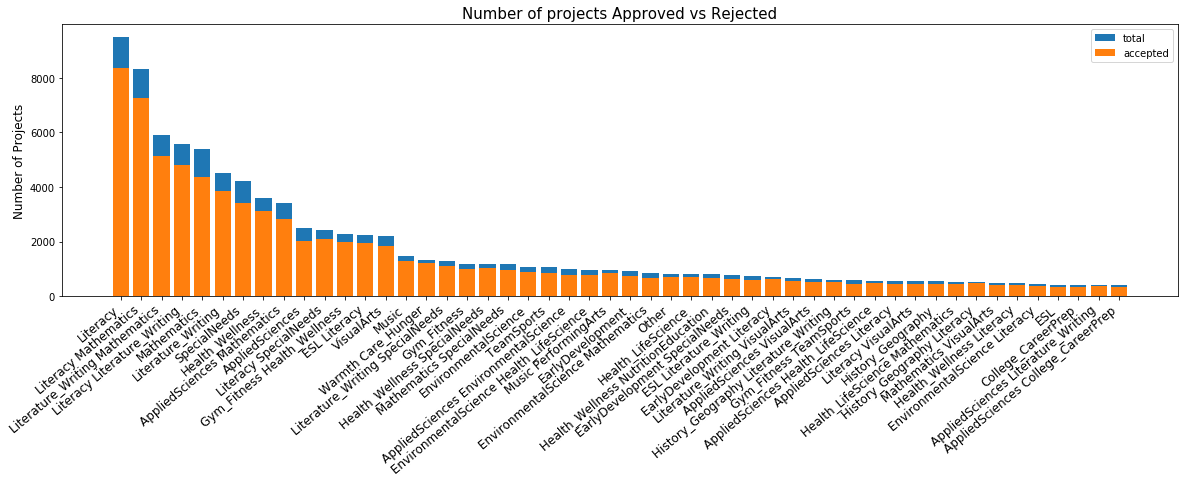

                clean_subcategories  project_is_approved  Total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  Total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [36]:
univariate_barplot(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [63]:
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

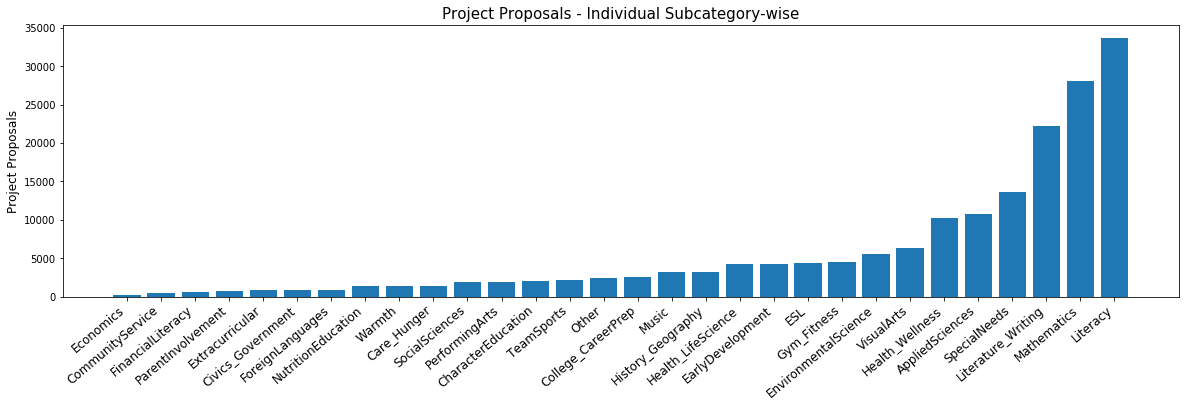

In [64]:
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

plt.figure(figsize=(20,5))
ind = np.arange(len(sorted_sub_cat_dict))
p1  = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Project Proposals', fontsize = 12)
plt.title('Project Proposals - Individual Subcategory-wise', fontsize = 15)
plt.xticks(ind, list(sorted_sub_cat_dict.keys()), fontsize = 12, rotation = 40, ha = 'right')
plt.show()

#### SUMMARY: 

* If literacy is present as one of the subject sub-categories for the project, then we are getting the largest number of submissions. This is followed by Mathematics and Literature writing. 


* Lowest number of submissions are received when Economics is one of the sub-category in the project proposal. 

In [65]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20}:{:10}".format(i,j))

Economics           :       269
CommunityService    :       441
FinancialLiteracy   :       568
ParentInvolvement   :       677
Extracurricular     :       810
Civics_Government   :       815
ForeignLanguages    :       890
NutritionEducation  :      1355
Warmth              :      1388
Care_Hunger         :      1388
SocialSciences      :      1920
PerformingArts      :      1961
CharacterEducation  :      2065
TeamSports          :      2192
Other               :      2372
College_CareerPrep  :      2568
Music               :      3145
History_Geography   :      3171
Health_LifeScience  :      4235
EarlyDevelopment    :      4254
ESL                 :      4367
Gym_Fitness         :      4509
EnvironmentalScience:      5591
VisualArts          :      6278
Health_Wellness     :     10234
AppliedSciences     :     10816
SpecialNeeds        :     13642
Literature_Writing  :     22179
Mathematics         :     28074
Literacy            :     33700


### 1.2.6 Univariate Analysis: Text features (Title)

In [50]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

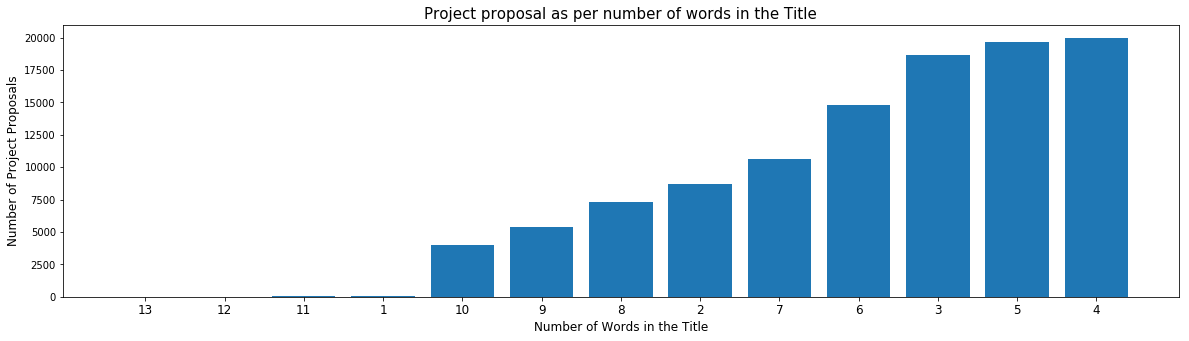

In [82]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039

word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.xticks(ind, list(word_dict.keys()), fontsize = 12)
plt.ylabel('Number of Project Proposals', fontsize = 12)
plt.xlabel('Number of Words in the Title', fontsize = 12)
plt.title('Project proposal as per number of words in the Title', fontsize = 15)
plt.show()

#### SUMMARY:

* Higest number of the project proposal received has 4 words in the title. This is closely followed by the project proposals with 3 and 5 words in the Title.

 
* Most of the project proposals received has the title in range of 2 - 8 words. There are negligble number of project proposals having unusually large or small project title i.e having more than 10 words or less than 2 words.

In [101]:
# Now let's see if the length of the words in the title infuences the acceptance or rejections 

approved_title_word_count = project_data[project_data['project_is_approved'] == 1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved'] == 0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

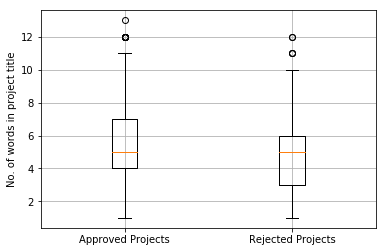

In [103]:
# Plotting the Box Plot
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html

plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('No. of words in project title')
plt.grid()
plt.show()

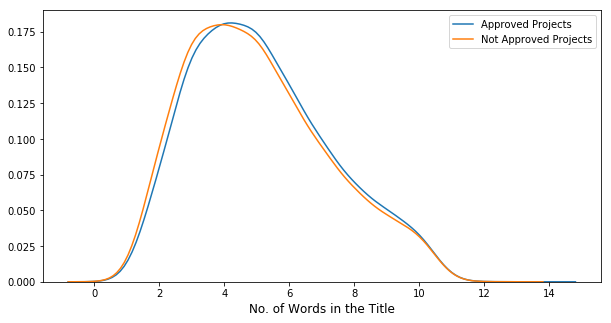

In [108]:
plt.figure(figsize=(10,5))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw = 0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw = 0.6)
plt.xlabel('No. of Words in the Title', fontsize = 12)
plt.legend()
plt.show()

#### SUMMARY : 

* Among all the project proposals received, a high number of them have around 4 words in the title as compared to the other title lengths. This is applicable for both approved and rejected projects. 


* As seen from the above KDE plot there is a high overlap among the class labels. Hence we can conclude that the approval or rejection of the project is not dependent on the number of words in the title. 

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [11]:
# Analyze whether the total word count of essays for infuences the accpetance or rejection decision 
# merge column text dataframes :

project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [5]:
approved_essay_word_count = project_data[project_data['project_is_approved'] == 1]["essay"].str.split().apply(len)
approved_essay_word_count = approved_essay_word_count.values

rejected_essay_word_count = project_data[project_data['project_is_approved'] == 0]["essay"].str.split().apply(len)
rejected_essay_word_count = rejected_essay_word_count.values

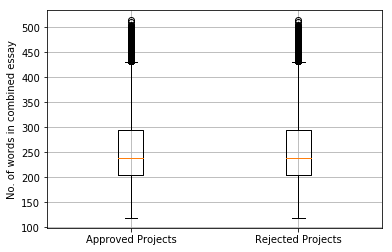

In [9]:
plt.boxplot([approved_essay_word_count, approved_essay_word_count])

plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('No. of words in combined essay')
plt.grid()
plt.show()

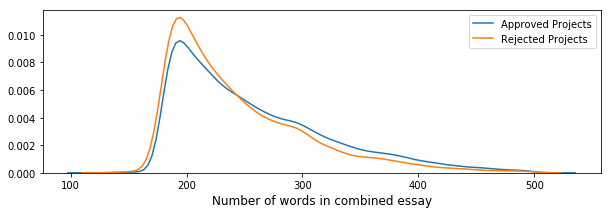

In [10]:
plt.figure(figsize=(10,3))
sns.distplot(approved_essay_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_essay_word_count, hist=False, label="Rejected Projects")
plt.xlabel('Number of words in combined essay', fontsize = 12)
plt.legend()
plt.show()

#### SUMMARY:  

* Almost all the project proposals received have essay (combined) more than 100 words and less than 500. 


* Among all the project proposals received, most of the essays have around 200 to 300 words. This is applicable for both approved and rejected projects. The variation in the number of words is comparatively higher among the approved projects, while in case of rejected projects a good number of them are concentrated around 200. 


* As seen from the above KDE plot there is a high overlap among the class labels. Hence we can conclude that the approval or rejection of the project cannot be concluded based on the number of words in the essay. 


### 1.2.8 Univariate Analysis: Cost per project

In [12]:
resource_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [13]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [14]:
price_data.head()

id    price  quantity
0  p000001   459.56         7
1  p000002   515.89        21
2  p000003   298.97         4
3  p000004  1113.69        98
4  p000005   485.99         8

In [15]:
# join two dataframes in python

project_data = pd.merge(project_data, price_data, on='id', how='left')

In [16]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  
0  My students are English learners that are work...  154.6        23  
1  Our students arrive to our school eager to lea...  299.0         1

In [51]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

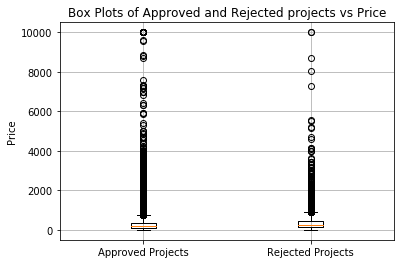

In [53]:
# plotting the boxplot for the price data

plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Approved and Rejected projects vs Price')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

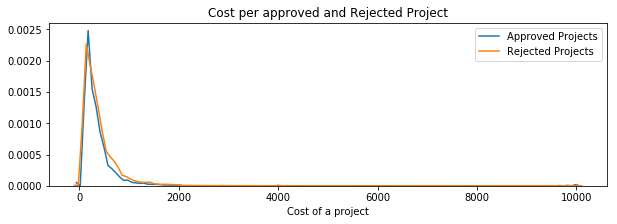

In [57]:
# plotting a kde distribution plot for cost of the project for approved and rejected projects

plt.figure(figsize = (10,3))
sns.distplot(approved_price, hist = False, label = 'Approved Projects')
sns.distplot(rejected_price, hist = False, label = 'Rejected Projects')
plt.title('Cost per approved and Rejected Project' )
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

#### SUMMARY

* Almost all of the project proposals received has cost requirement less than 1000. The projects requiring total price more than 1000 is very less. This observation is same irrespective of whether the project is approved or rejected. 


* There is a high overlap throughout among the target variables - approved projects and rejected projects when cost of the project is under considered. So, nothing significant can be concluded from the above plot. 

In [72]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0, 101, 5):
    x.add_row([i,round(np.percentile(approved_price, i), 3), round(np.percentile(rejected_price, i), 3)])
    
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

#### SUMMARY: 

*  About 95% of the project proposals receive has cost requirement less than 1000 $. 


*  In general, it can be observed that the cost requirement of the project proposal rejected was higher than the cost requirement of the accepted proposal. 

<h3><font color='red'>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

In [63]:
# Now let'see how the number of project proposals received varies based on the teacher number of previously posted projects 

approved_on_previous_project_submissions = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values

rejected_on_previous_project_submissions = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values

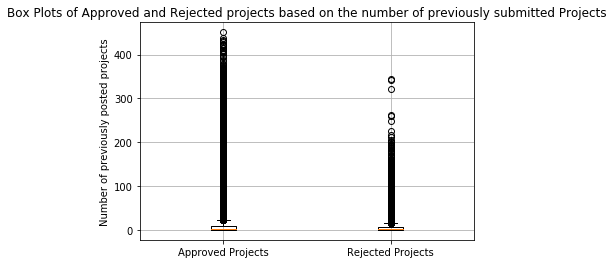

In [66]:
# plotting the boxplot for the previous project submissions data

plt.boxplot([approved_on_previous_project_submissions, rejected_on_previous_project_submissions])
plt.title('Box Plots of Approved and Rejected projects based on the number of previously submitted Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Number of previously posted projects')
plt.grid()
plt.show()

#### SUMMARY: 

> Large number of the project proposals received are having near about 0 previous project submissions by same teacher. i.e Teachers submitting the project proposal for the first time constitue the majority. 


> If the number of previously submitted project proposals are more than 250, then the chance of current project proposal approval is almost 100 %. 

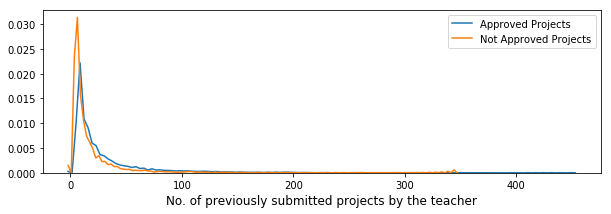

In [65]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_on_previous_project_submissions,label="Approved Projects")
sns.kdeplot(rejected_on_previous_project_submissions,label="Not Approved Projects")
plt.xlabel('No. of previously submitted projects by the teacher', fontsize = 12)
plt.legend()
plt.show()

#### SUMMARY : 

* Most of the project proposals received has 0 previous submissions. A very high volume of the previous project submissions is is a single-digit number. 


* The curve falls drastically indicating, the number of previously submitted projects above 100 is negligible.These observations are same for both the approved as well as rejected projects. 


* Altough there is a good overlap, few things can be observed - 

> The peak of the curve for the not approved projects is above the approved projects curve near 0.                          This indicates that the chance of project proposal getting rejected for the first timers is comparatively higher. 

> If previous project submissions are above 350, then the chance of project proposal getting accepted is 100%. This observation is consistent with our previous observation in box plot for this feature. 

<h3><font color='red'>1.2.10 Univariate Analysis: project_resource_summary</font></h3>

In [17]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  
0  My students are English learners that are work...  154.6        23  
1  Our students arrive to our school eager to lea...  299.0         1

In [178]:
# To Check how the word length of the project_resource_summary influences the project acceptance or rejection decision

approved_proj_summary_wordcount = project_data[project_data['project_is_approved'] == 1]['project_resource_summary'].str.split().apply(len)
approved_proj_summary_wordcount = approved_proj_summary_wordcount.values

rejected_proj_summary_wordcount = project_data[project_data['project_is_approved'] == 0]['project_resource_summary'].str.split().apply(len)
rejected_proj_summary_wordcount = rejected_proj_summary_wordcount.values

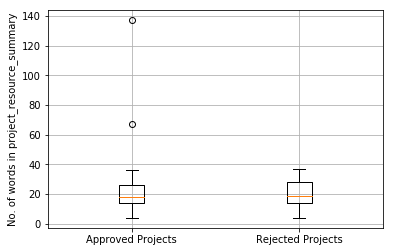

In [179]:
plt.boxplot([approved_proj_summary_wordcount, rejected_proj_summary_wordcount])

plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('No. of words in project_resource_summary')
plt.grid()
plt.show()

#### SUMMARY: 

* For almost all the projects, the Project resource summary is in range of 5 - 35 words, with median around 20 words. 


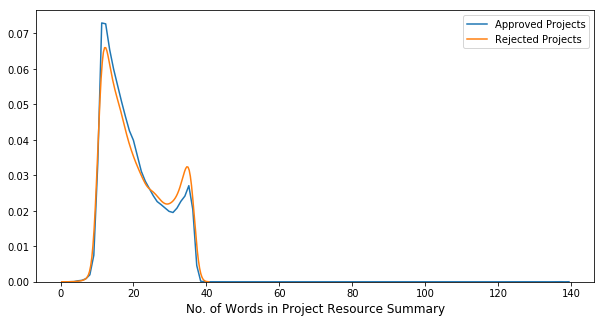

In [183]:
plt.figure(figsize=(10,5))
sns.distplot(approved_proj_summary_wordcount, hist = False, label="Approved Projects")
sns.distplot(rejected_proj_summary_wordcount, hist = False, label="Rejected Projects")
plt.xlabel('No. of Words in Project Resource Summary', fontsize = 12)
plt.legend()
plt.show()

#### SUMMARY: 

* Projects with the resource summary of about 10 - 20 words has higher chances of getting approved. Projects with reource summary of about 30 - 40 words has comparatively higher chance of getting rejected. 

In [18]:
# To check whether the presence of the number in the project resource summary influences the project acceptance 
# https://www.geeksforgeeks.org/python-extract-numbers-from-string/

project_data['num_in_resource_summary'] = 'No'

for i in range(len(project_data)):
    for element in project_data['project_resource_summary'].iloc[i].split():
        if element.isdigit():
            project_data['num_in_resource_summary'].iloc[i] = 'Yes'

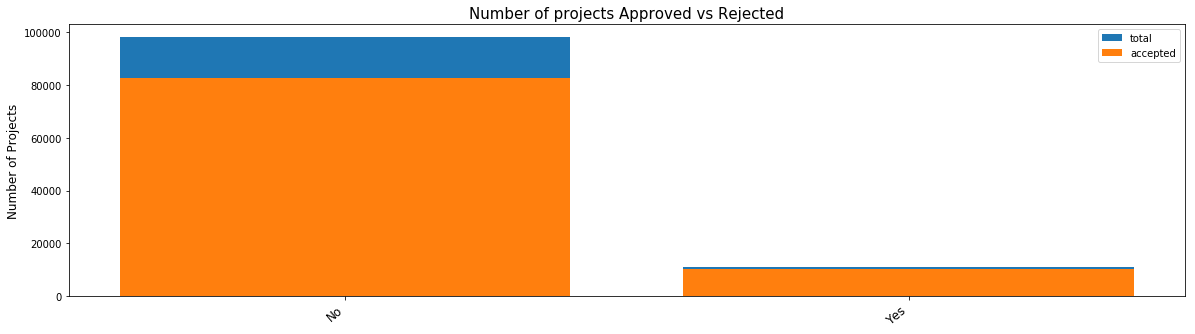

  num_in_resource_summary  project_is_approved  Total       Avg
0                      No                82562  98011  0.842375
1                     Yes                10144  11237  0.902732
  num_in_resource_summary  project_is_approved  Total       Avg
0                      No                82562  98011  0.842375
1                     Yes                10144  11237  0.902732


In [19]:
univariate_barplot(project_data, 'num_in_resource_summary', 'project_is_approved', top= False)

#### SUMMARY : 

* As seen from above stack plot, when a numeral is not present in the Project resource summary, the project acceptance rate is 84.23%.


* If the numeral digit is presentin the Project resource summary, the project acceptance rate raises by about 6% to 90.27%. Thus, we can conclude that the project proposal is more likely to get accepted when the appropriate number for the required stuff is specified in the Project proposal summary. 

#### To check if the presence of word 'STEM' in the project resource summary has any effect on the project acceptance rate 

In [20]:
#How does the presence of word 'STEM' in the project summary influences the approval or rejection of the project proposal ? 

project_data['STEM_in_project_summary'] = 'No'

for i in range(len(project_data)):
    for word in project_data['project_resource_summary'].iloc[i].split():
        if word in ['STEM', 'S.T.E.M', 'stem']:
            project_data['STEM_in_project_summary'].iloc[i] = 'Yes'

In [21]:
project_data['STEM_in_project_summary'].value_counts()

No     107026
Yes      2222
Name: STEM_in_project_summary, dtype: int64

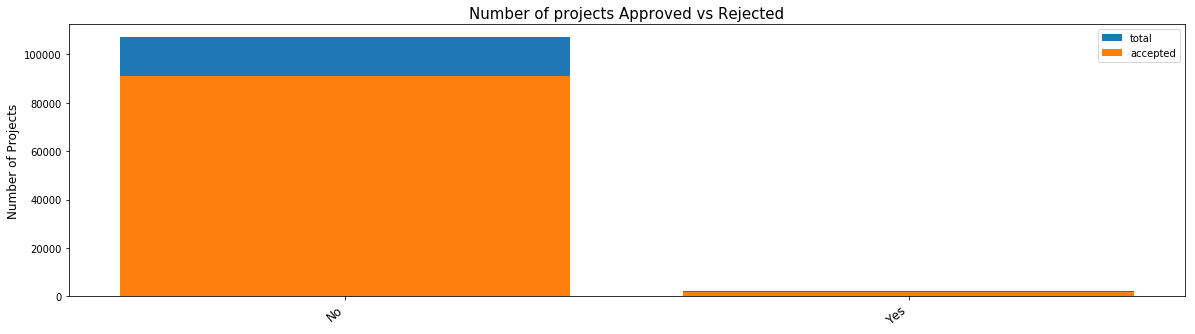

  STEM_in_project_summary  project_is_approved   Total       Avg
0                      No                90956  107026  0.849850
1                     Yes                 1750    2222  0.787579
  STEM_in_project_summary  project_is_approved   Total       Avg
0                      No                90956  107026  0.849850
1                     Yes                 1750    2222  0.787579


In [194]:
univariate_barplot(project_data, 'STEM_in_project_summary', 'project_is_approved', top= False)

#### SUMMARY: 

* As oppose to our hypothesis that the presence of word STEM in the Project resource summary improves the chances of project getting approved, the analysis has actually showed us that it infact decreases the chances of project approval!  


* Moreover, STEM is present in less than 2 % of the project proposal summary and project acceptance/rejection could be due to other factors too, hence it is not significant enough to draw any conclusions. 

In [23]:
# We added few rows and customized few others in the present dataframe. 
# Take a backup of the dataframe just in case the kernel connection breaks
project_data.to_csv('project_data2.csv', index = False)

## 1.3 Data Pre-Processing 

1. Note that after Univariate analysis in the section 1.2, we'll be considering only the below attributes for the further analysis -

       *  CATEGORICAL DATA
       - teacher_prefix : categorical data
       - school_state : categorical 
       - project_grade_category : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       
       * TEXT DATA 
       - project_title : text data
       - essay text : text data
       - project_resource_summary: text data
       
       * NUMERICAL DATA
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical
       - quantity : numerical
       
2. Also, henceforth we will be performing all further processing and analysis on the random 12k datapoints sampled from the dataset of 109k datapoints. 

In [2]:
project_data2 = pd.read_csv('project_data2.csv')

In [3]:
project_data2.shape 

(109248, 22)

In [4]:
# randomly sample 12K datapoints 
# https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/

data = project_data2.sample(n = 12000, random_state = 42)
print(data.shape) 
print('=' * 50)
print(data.columns)

(12000, 22)
Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'num_in_resource_summary', 'STEM_in_project_summary'],
      dtype='object')


In [245]:
project_data['project_is_approved'].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

In [244]:
data['project_is_approved'].value_counts()

1    10211
0     1789
Name: project_is_approved, dtype: int64

Note: We sampled 12,000 datapoints randomly from the original 109,000 datapoints. The ratio of the class labels in the sampled data is same as that in the original data. 

### 1.3.1 Categorical Data Pre-processing 

#### 1.3.1.1 Teacher Prefix 

In [7]:
data['teacher_prefix'].value_counts()

Mrs.       6290
Ms.        4259
Mr.        1174
Teacher     275
Dr.           2
Name: teacher_prefix, dtype: int64

In [8]:
# checking if any null rows exist 

data['teacher_prefix'].isnull().sum()

0

> No further preprocessing needed. 

#### 1.3.1.2 School State

In [9]:
data['school_state'].value_counts(dropna = False)

CA    1630
NY     816
TX     794
FL     652
NC     579
IL     494
GA     449
SC     442
PA     357
MI     334
IN     288
MO     284
WA     273
OH     271
MA     269
OK     261
LA     252
AZ     237
NJ     232
VA     229
UT     207
AL     205
WI     185
CT     182
TN     178
KY     172
MS     155
NV     154
MD     151
OR     141
MN     137
AR     117
CO     114
ID      75
ME      67
KS      66
NM      65
IA      64
DC      61
HI      57
WV      54
AK      43
DE      36
RI      34
NE      30
NH      30
SD      28
MT      24
WY      11
ND       8
VT       6
Name: school_state, dtype: int64

> No further pre-processing required. 

#### 1.3.1.3 project_grade_category

In [10]:
## https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html

data['project_grade_category'].value_counts(dropna = False) 

Grades PreK-2    4758
Grades 3-5       4090
Grades 6-8       1920
Grades 9-12      1232
Name: project_grade_category, dtype: int64

In [5]:
# replacing the spaces after 'Grades' with '_' so that 'Grade' will not be counted as a seperate entity. 
## https://www.geeksforgeeks.org/python-string-replace/

data['project_grade_category'] = data['project_grade_category'].str.replace(' ', '_')
data['project_grade_category'] = data['project_grade_category'].str.replace('-', '_')
data['project_grade_category'].value_counts()

Grades_PreK_2    4758
Grades_3_5       4090
Grades_6_8       1920
Grades_9_12      1232
Name: project_grade_category, dtype: int64

> No further pre-processing required. 

#### 1.3.1.4 clean_categories

In [12]:
data['clean_categories'].value_counts(dropna = False)

Literacy_Language                       2549
Math_Science                            1898
Literacy_Language Math_Science          1634
Health_Sports                           1158
Music_Arts                               573
SpecialNeeds                             468
Literacy_Language SpecialNeeds           453
AppliedLearning                          413
Math_Science Literacy_Language           257
History_Civics                           213
Math_Science SpecialNeeds                210
AppliedLearning Literacy_Language        210
Literacy_Language Music_Arts             178
Math_Science Music_Arts                  171
AppliedLearning SpecialNeeds             167
History_Civics Literacy_Language         155
Warmth Care_Hunger                       142
Math_Science AppliedLearning             140
Health_Sports SpecialNeeds               139
AppliedLearning Math_Science             110
AppliedLearning Music_Arts                81
Health_Sports Literacy_Language           80
Math_Scien

> We already performed the pre-preprocessing on Project Categories data in Section 1.2 while performing Univariate analysis on data. No further processing is needed. 

#### 1.3.1.5 clean_subcategories

In [13]:
data['clean_subcategories'].value_counts(dropna = False)

Literacy                                   1062
Literacy Mathematics                        933
Literature_Writing Mathematics              657
Mathematics                                 608
Literacy Literature_Writing                 605
Literature_Writing                          472
SpecialNeeds                                468
Health_Wellness                             403
AppliedSciences Mathematics                 345
AppliedSciences                             305
Literacy SpecialNeeds                       295
VisualArts                                  259
Gym_Fitness Health_Wellness                 252
ESL Literacy                                207
Music                                       157
Gym_Fitness                                 152
Warmth Care_Hunger                          142
Literature_Writing SpecialNeeds             138
Mathematics SpecialNeeds                    135
Health_Wellness SpecialNeeds                118
EnvironmentalScience                    

> Likewiese, We also performed the pre-preprocessing on Project SubCategories in Section 1.2 while performing Univariate analysis on data. No further processing is required. 

### 1.3.2 Text Data Pre-Processing

#### 1.3.2.1 Essay text 

In [14]:
data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
105447      157247  p118457  ba6d96c0de8f0396f80fbf4b549c4217        Teacher   
69262       164744  p013133  60d8c1a778cab80242a2df0fd3e0ff09           Mrs.   

       school_state project_submitted_datetime project_grade_category  \
105447           NC        2016-07-05 16:12:10            Grades_9_12   
69262            NY        2016-10-15 16:53:46             Grades_3_5   

                             project_title  \
105447  Rain Barrels for the School Garden   
69262                     Wobbly Learning!   

                                          project_essay_1  \
105447  Environmental science students have no idea wh...   
69262   My students need six Learniture Active Learnin...   

                                          project_essay_2  ...  \
105447  We are in the process of filing lots of grants...  ...   
69262   My students are excited to learn science but t...  ...   

                                 project_resource_summary  \
105447  My students need these rain barrels to collect...   
69262   My students need five Wobble Chair,They have s...   

       teacher_number_of_previously_posted_projects project_is_approved  \
105447                                            0                   1   
69262                                            20                   0   

                 clean_categories                clean_subcategories  \
105447  Math_Science SpecialNeeds  EnvironmentalScience SpecialNeeds   
69262                SpecialNeeds                       SpecialNeeds   

                                                    essay   price quantity  \
105447  Environmental science students have no idea wh...   93.69        4   
69262   My students need six Learniture Active Learnin...  209.85        5   

        num_in_resource_summary  STEM_in_project_summary  
105447                       No                       No  
69262                        No                       No  

[2 rows x 22 columns]

In [15]:
# printing some random essays.
print(data['essay'].values[9])
print("="*100)
print(data['essay'].values[99])
print("="*100)
print(data['essay'].values[999])
print("="*100)
print(data['essay'].values[9999])
print("="*100)

Do you remember finding that one special book that you could not put down and that you read at home at bedtime with a flashlight?  My students love to read, and they love having access to great books! I teach in a school where more than half of my students receive free or reduced price lunches. Many of my students come from homes where both parents work to make ends meet, and there is not much money left over for books. My 6th grade students love to read, and since books are not readily available in most of their homes, they must depend on our school library for their reading material. \r\n\r\nMy district works very hard to enhance student learning. Our library is able to have one or two copies of the most popular new books as we know that providing great reading material encourages student engagement. But our budget is also very tight, so our library cannot always keep up. There is more students demand for books than there are copies of the books.I would like to have 7 Fire Tablets fo

In [6]:
# https://stackoverflow.com/a/47091490/4084039

import re

def decontracted(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not",  phrase)
    
    #general
    phrase = re.sub(r"n\'t", " not",   phrase)
    phrase = re.sub(r"\'re", " are",   phrase)
    phrase = re.sub(r"\'s",  " is",    phrase)
    phrase = re.sub(r"\'d",  " would", phrase)
    phrase = re.sub(r"\'ll", " will",  phrase)
    phrase = re.sub(r"\'t",  " not",   phrase)
    phrase = re.sub(r"\'ve", " have",  phrase)
    phrase = re.sub(r"\'m",  " am",    phrase)
    phrase = re.sub(r"\'em", " them",  phrase)
    return phrase

In [7]:
sent = decontracted(data['essay'].values[9])
print(sent)

Do you remember finding that one special book that you could not put down and that you read at home at bedtime with a flashlight?  My students love to read, and they love having access to great books! I teach in a school where more than half of my students receive free or reduced price lunches. Many of my students come from homes where both parents work to make ends meet, and there is not much money left over for books. My 6th grade students love to read, and since books are not readily available in most of their homes, they must depend on our school library for their reading material. \r\n\r\nMy district works very hard to enhance student learning. Our library is able to have one or two copies of the most popular new books as we know that providing great reading material encourages student engagement. But our budget is also very tight, so our library cannot always keep up. There is more students demand for books than there are copies of the books.I would like to have 7 Fire Tablets fo

In [8]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/

sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Do you remember finding that one special book that you could not put down and that you read at home at bedtime with a flashlight?  My students love to read, and they love having access to great books! I teach in a school where more than half of my students receive free or reduced price lunches. Many of my students come from homes where both parents work to make ends meet, and there is not much money left over for books. My 6th grade students love to read, and since books are not readily available in most of their homes, they must depend on our school library for their reading material.     My district works very hard to enhance student learning. Our library is able to have one or two copies of the most popular new books as we know that providing great reading material encourages student engagement. But our budget is also very tight, so our library cannot always keep up. There is more students demand for books than there are copies of the books.I would like to have 7 Fire Tablets for st

In [9]:
# remove spacial character: https://stackoverflow.com/a/5843547/4084039

sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Do you remember finding that one special book that you could not put down and that you read at home at bedtime with a flashlight My students love to read and they love having access to great books I teach in a school where more than half of my students receive free or reduced price lunches Many of my students come from homes where both parents work to make ends meet and there is not much money left over for books My 6th grade students love to read and since books are not readily available in most of their homes they must depend on our school library for their reading material My district works very hard to enhance student learning Our library is able to have one or two copies of the most popular new books as we know that providing great reading material encourages student engagement But our budget is also very tight so our library cannot always keep up There is more students demand for books than there are copies of the books I would like to have 7 Fire Tablets for students to use for 

In [10]:
# removing all the stopwords (except 'no', 'nor' and 'not')
# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

Note: We are skipping the 'removing words with number' step because in this context, it is quiet possible that some required equipments may have numbers in the text. 

In [11]:
# Combining all the above statemennts 

from tqdm import tqdm
preprocessed_essays = []

for sentence in tqdm(data['essay'].values):
    sent = decontracted(sentence) #decontracts the english words in the corpus
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent) #removes the special characters
    
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords) #removing the stopwords 
    preprocessed_essays.append(sent.strip())

100%|███████████████████████████████████| 12000/12000 [00:19<00:00, 617.12it/s]


<h4><font color='red'>1.3.2.2 Project title Text</font></h4>

In [22]:
data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
105447      157247  p118457  ba6d96c0de8f0396f80fbf4b549c4217        Teacher   
69262       164744  p013133  60d8c1a778cab80242a2df0fd3e0ff09           Mrs.   

       school_state project_submitted_datetime project_grade_category  \
105447           NC        2016-07-05 16:12:10            Grades_9_12   
69262            NY        2016-10-15 16:53:46             Grades_3_5   

                             project_title  \
105447  Rain Barrels for the School Garden   
69262                     Wobbly Learning!   

                                          project_essay_1  \
105447  Environmental science students have no idea wh...   
69262   My students need six Learniture Active Learnin...   

                                          project_essay_2  ...  \
105447  We are in the process of filing lots of grants...  ...   
69262   My students are excited to learn science but t...  ...   

                                 project_resource_summary  \
105447  My students need these rain barrels to collect...   
69262   My students need five Wobble Chair,They have s...   

       teacher_number_of_previously_posted_projects project_is_approved  \
105447                                            0                   1   
69262                                            20                   0   

                 clean_categories                clean_subcategories  \
105447  Math_Science SpecialNeeds  EnvironmentalScience SpecialNeeds   
69262                SpecialNeeds                       SpecialNeeds   

                                                    essay   price quantity  \
105447  Environmental science students have no idea wh...   93.69        4   
69262   My students need six Learniture Active Learnin...  209.85        5   

        num_in_resource_summary  STEM_in_project_summary  
105447                       No                       No  
69262                        No                       No  

[2 rows x 22 columns]

In [23]:
# printing few random project titles

print(data['project_title'].values[9])
print("="*50)
print(data['project_title'].values[99])
print("="*50)
print(data['project_title'].values[999])
print("="*50)
print(data['project_title'].values[9999])
print("="*50)

Engaging Students and Families to Read Together
Wiggle Room
Ms. Marshall's Listening Library
Super Special Organization


>  Note: I have added re.sub(r"\'em", " them", phrase) in the decontracted definition in order to tackle words like 'em' -> them. 'them' will eventually get removed along with other stopwords. 

In [12]:
#combining all the text processing statements just like above 

preprocessed_title = []

for title in tqdm(data['project_title'].values):
    title = decontracted(title)
    title = re.sub('[^A-Za-z0-9]+', ' ', title) 
    
    title = ' '.join(e.lower() for e in title.split() if e.lower() not in stopwords) 
    preprocessed_title.append(title.strip())

100%|██████████████████████████████████| 12000/12000 [00:01<00:00, 7575.32it/s]


In [13]:
print(preprocessed_title[9])
print("="*50)
print(preprocessed_title[99])
print("="*50)
print(preprocessed_title[999])
print("="*50)
print(preprocessed_title[9999])
print("="*50)

engaging students families read together
wiggle room
ms marshall listening library
super special organization


<h3><font color='red'>1.3.2.3 Project Resource Summary Text</font></h3>

In [14]:
# printing few random project resource summaries 

print(data['project_resource_summary'].values[8466])
print("="*50)
print(data['project_resource_summary'].values[71])
print("="*50)
print(data['project_resource_summary'].values[791])
print("="*50)
print(data['project_resource_summary'].values[46])
print("="*50)

My students need indoor plant lighting to grow their plants and their minds.
My students need fidget toys to use when they want to relax and cool down. I have all different learners in my room and they sometimes need little mind breaks to achieve success!
My students need one instax camera in order to foster a successful classroom community.
My students need an inviting and fun place to read and learn. using the rug and soft pillows, students will be able to learn around our room. Students will use the games to learn essential skills.


> Observation => 'My', 'students', 'need' and 'want' are common in every project resource summary. So, we are going to add these words to the set of custom_stopwords. 

In [15]:
# removing all the stopwords (except 'no', 'nor' and 'not')
# adding words like 'students', 'need', 'want', 'sometimes' that are either common throughout or doesn't serve purpose. 
# https://gist.github.com/sebleier/554280

custom_stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", 'need', 'students', 'want', 'sometimes']

In [16]:
#combining all the project resource summaries just like above 

preprocessed_summary = []

for summary in tqdm(data['project_resource_summary'].values):
    summary = decontracted(summary)
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary) 
    
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in custom_stopwords) 
    preprocessed_summary.append(summary.strip())

100%|██████████████████████████████████| 12000/12000 [00:03<00:00, 3245.69it/s]


In [17]:
print(preprocessed_summary[8466])
print("="*50)
print(preprocessed_summary[71])
print("="*50)
print(preprocessed_summary[791])
print("="*50)
print(preprocessed_summary[46])
print("="*50)

indoor plant lighting grow plants minds
fidget toys use relax cool different learners room little mind breaks achieve success
one instax camera order foster successful classroom community
inviting fun place read learn using rug soft pillows able learn around room use games learn essential skills


### 1.3.3 Numerical Data Pre-Processing

#### 1.3.3.1  teacher_number_of_previously_posted_projects

In [85]:
print(data['teacher_number_of_previously_posted_projects'].values)
data['teacher_number_of_previously_posted_projects'].isnull().sum()

[ 0 20  2 ...  1  0 27]


0

No further pre-processing required.

#### 1.3.3.2   price

In [88]:
print(data['price'].values)
data['price'].isnull().sum()

[  93.69  209.85  102.31 ... 1128.99  266.68  819.08]


0

We'll standardize this feature in the subsequent section.

#### 1.3.3.3 quantity

In [90]:
print(data['quantity'].values)
data['quantity'].isnull().sum()

[  4   5   2 ...   3 169   8]


0

No further processing required.

## 1. 4 Preparing data for models

In [30]:
data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'num_in_resource_summary', 'STEM_in_project_summary'],
      dtype='object')

### 1.4.1 Vectorizing Categorical data

### 1.4.1.1 teacher_prefix

In [18]:
# we use count vectorizer to convert the values into one hot encoded features
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

from sklearn.feature_extraction.text import CountVectorizer 
vectorizer = CountVectorizer(lowercase = False, binary = True)
vectorizer.fit(data['teacher_prefix'].values)
print(vectorizer.get_feature_names())

prefix_one_hot = vectorizer.transform(data['teacher_prefix'].values)
print("Shape of matrix after one hot encoding ",prefix_one_hot.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']
Shape of matrix after one hot encoding  (12000, 5)


### 1.4.1.2 school_state

In [19]:
vectorizer = CountVectorizer(lowercase = False, binary = True)
vectorizer.fit(data['school_state'].values)
print(vectorizer.get_feature_names())

state_one_hot = vectorizer.transform(data['school_state'].values)
print("Shape of state matrix after one hot encoding : ",state_one_hot.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of state matrix after one hot encoding :  (12000, 51)


### 1.4.1.3 project_grade_category

In [20]:
vectorizer = CountVectorizer(lowercase = False, binary = True)
vectorizer.fit(data['project_grade_category'].values)
print(vectorizer.get_feature_names())

project_grade_one_hot = vectorizer.transform(data['project_grade_category'].values)
print("\nShape of Grade category matrix after one hot encoding : ",project_grade_one_hot.shape)

['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']

Shape of Grade category matrix after one hot encoding :  (12000, 4)


### 1.4.1.4 clean_categories 

In [21]:
# dict sort by value (https://stackoverflow.com/a/613218/4084039)
# count of all the words in corpus (https://stackoverflow.com/a/22898595/4084039) 

from collections import Counter 

my_counter = Counter()
for word in data['clean_categories'].values:
    my_counter.update(word.split())
    
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key = lambda kv: kv[1]))

In [35]:
my_counter

Counter({'Math_Science': 4617,
         'SpecialNeeds': 1506,
         'History_Civics': 649,
         'Music_Arts': 1098,
         'Literacy_Language': 5673,
         'AppliedLearning': 1310,
         'Health_Sports': 1580,
         'Warmth': 153,
         'Care_Hunger': 153})

In [22]:
vectorizer = CountVectorizer(vocabulary = list(sorted_cat_dict.keys()), lowercase = False, binary = True)
vectorizer.fit(data['clean_categories'].values)
print(vectorizer.get_feature_names())

categories_one_hot = vectorizer.transform(data['clean_categories'].values)
print("\nShape of cleaned category matrix after one hot encoding : ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']

Shape of cleaned category matrix after one hot encoding :  (12000, 9)


### 1.4.1.5 clean_sub_categories 

In [23]:
my_counter = Counter()
for word in data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key = lambda kv: kv[1]))

In [38]:
sub_cat_dict

{'EnvironmentalScience': 614,
 'SpecialNeeds': 1506,
 'History_Geography': 357,
 'SocialSciences': 209,
 'VisualArts': 680,
 'Literacy': 3696,
 'AppliedSciences': 1170,
 'FinancialLiteracy': 67,
 'Mathematics': 3119,
 'Literature_Writing': 2359,
 'EarlyDevelopment': 454,
 'Health_LifeScience': 482,
 'Gym_Fitness': 532,
 'Health_Wellness': 1111,
 'ESL': 425,
 'Music': 334,
 'NutritionEducation': 150,
 'Extracurricular': 87,
 'CharacterEducation': 222,
 'TeamSports': 239,
 'Civics_Government': 90,
 'College_CareerPrep': 278,
 'Other': 260,
 'Warmth': 153,
 'Care_Hunger': 153,
 'PerformingArts': 199,
 'ParentInvolvement': 77,
 'ForeignLanguages': 114,
 'Economics': 28,
 'CommunityService': 47}

In [24]:
vectorizer = CountVectorizer(vocabulary = list(sorted_sub_cat_dict.keys()), lowercase = False, binary = True)
vectorizer.fit(data['clean_subcategories'].values)
print(vectorizer.get_feature_names())

subcategories_one_hot = vectorizer.transform(data['clean_subcategories'].values)
print("\nShape of cleaned sub-category matrix after one hot encoding : ",subcategories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'PerformingArts', 'SocialSciences', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'ESL', 'EarlyDevelopment', 'Health_LifeScience', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']

Shape of cleaned sub-category matrix after one hot encoding :  (12000, 30)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words on Essay text

In [25]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of Essay matrix after one hot encoding : ",text_bow.shape)

Shape of Essay matrix after one hot encoding :  (12000, 6701)


<h4><font color='red'> 1.4.2.2 Bag of Words on `project_title`</font></h4>

In [26]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df = 10)
project_title_bow = vectorizer.fit_transform(preprocessed_title)
print("Shape of Project title matrix after one hot encoding : ",project_title_bow.shape)

Shape of Project title matrix after one hot encoding :  (12000, 700)


<h4><font color='red'> 1.4.2.3 Bag of Words on project_resource_summary</font></h4>

In [27]:
vectorizer = CountVectorizer(min_df=10)
resource_summary_bow = vectorizer.fit_transform(preprocessed_summary)
print("Shape of Resource Summary matrix after one hot encoding : ",resource_summary_bow.shape)

Shape of Resource Summary matrix after one hot encoding :  (12000, 1645)


#### 1.4.2.4 TFIDF vectorizer on Essay text

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of Essay matrix after one hot encoding :",text_tfidf.shape)

Shape of Essay matrix after one hot encoding : (12000, 6701)


<h4><font color='red'> 1.4.2.5 TFIDF vectorizer on `project_title`</font></h4>

In [29]:
vectorizer = TfidfVectorizer(min_df = 10)
project_title_tfidf = vectorizer.fit_transform(preprocessed_title)
print("Shape of Project title matrix after one hot encoding : ",project_title_tfidf.shape)

Shape of Project title matrix after one hot encoding :  (12000, 700)


<h4><font color='red'> 1.4.2.6 TFIDF vectorizer on Project resource summary</font></h4>

In [30]:
vectorizer = TfidfVectorizer(min_df=10)
resource_summary_tfidf = vectorizer.fit_transform(preprocessed_summary)
print("Shape of Resource Summary matrix after one hot encoding : ",resource_summary_tfidf.shape)

Shape of Resource Summary matrix after one hot encoding :  (12000, 1645)


#### 1.4.2.7 Using Pretrained Models: Avg W2V

In [46]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

In [31]:
# stronging variables into pickle files python:
# http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [32]:
# average Word2Vec
# computing average word2vec for each essay

avg_w2v_essay = [] # the avg-w2v for each sentence is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # initialize a vector of zero length
    cnt_words = 0 # num of words with a valid vector in the review/sentence
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay.append(vector)
        
print("Total rows of vectors : ", len(avg_w2v_essay))
print("Length of each vector : ", len(avg_w2v_essay[0]))

100%|██████████████████████████████████| 12000/12000 [00:08<00:00, 1481.40it/s]


Total rows of vectors :  12000
Length of each vector :  300


<h4><font color='red'> 1.4.2.8 Using Pretrained Models: AVG W2V on `project_title`</font></h4>

In [33]:
# average Word2Vec
# computing average word2vec for each project title

avg_w2v_title = [] # the avg-w2v for each sentence is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # initialize a vector of zero length
    cnt_words = 0 # num of words with a valid vector in the review/sentence
    for word in sentence.split(): # for each word in the review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title.append(vector)
        
print("Total rows of vectors : ", len(avg_w2v_title))
print("Length of each vector : ", len(avg_w2v_title[0]))

100%|█████████████████████████████████| 12000/12000 [00:00<00:00, 13142.73it/s]


Total rows of vectors :  12000
Length of each vector :  300


<h4><font color='red'> 1.4.2.9 Using Pretrained Models: AVG W2V on `project_resource_summary`</font></h4>

In [34]:
# average Word2Vec
# computing average word2vec for each project resource summary

avg_w2v_summary = [] # the avg-w2v for each sentence is stored in this list
for sentence in tqdm(preprocessed_summary): # for each review/sentence
    vector = np.zeros(300) # initialize a 0 vector of length 300
    cnt_words = 0 # num of words with a valid vector in the review/sentence
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_summary.append(vector)
        
print("Total rows of vectors : ", len(avg_w2v_summary))
print("Length of each vector : ", len(avg_w2v_summary[0]))

100%|██████████████████████████████████| 12000/12000 [00:02<00:00, 5716.68it/s]


Total rows of vectors :  12000
Length of each vector :  300


#### 1.4.2.10 Using Pretrained Models: TFIDF weighted W2V - Essay text

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_essay_words = set(tfidf_model.get_feature_names())

In [36]:
# compute average word2vec for each essay 
tfidf_w2v_essay = [] # the tfidf-w2v for each sentence is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # initialize a 0 vector of length 300
    tf_idf_weight = 0 # initializing the number of words with valid vector in the review/sentence
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_essay_words):
            vec = model[word] # getting the vector for each word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # multiplying idf value and the tf value
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay.append(vector)
    
print("Total rows of vectors : ", len(tfidf_w2v_essay))
print("Length of each vector : ", len(tfidf_w2v_essay[0]))

100%|███████████████████████████████████| 12000/12000 [00:35<00:00, 342.84it/s]


Total rows of vectors :  12000
Length of each vector :  300


<h4><font color='red'> 1.4.2.11 Using Pretrained Models: TFIDF weighted W2V on `project_title`</font></h4>

In [37]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_title_words = set(tfidf_model.get_feature_names())

In [38]:
# compute average word2vec for each project title 
tfidf_w2v_title = [] # the tfidf-w2v for each sentence is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # initialize a 0 vector of length 300
    tf_idf_weight = 0 # initializing the number of words with valid vector in the review/sentence
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_title_words):
            vec = model[word] # getting the vector for each word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # multiplying idf value and the tf value
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title.append(vector)
    
print("Total rows of vectors : ", len(tfidf_w2v_title))
print("Length of each vector : ", len(tfidf_w2v_title[0]))

100%|██████████████████████████████████| 12000/12000 [00:02<00:00, 5847.62it/s]


Total rows of vectors :  12000
Length of each vector :  300


<h4><font color='red'> 1.4.2.12 Using Pretrained Models: TFIDF weighted W2V on `project_resource_summary`</font></h4>

In [39]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_summary)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_summary_words = set(tfidf_model.get_feature_names())

In [40]:
# compute average word2vec for each project resource summary
tfidf_w2v_summary = [] # the tfidf-w2v for each sentence is stored in this list
for sentence in tqdm(preprocessed_summary): # for each review/sentence
    vector = np.zeros(300) # initialize a 0 vector of length 300
    tf_idf_weight = 0 # initializing the number of words with valid vector in the review/sentence
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_summary_words):
            vec = model[word] # getting the vector for each word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # multiplying idf value and the tf value
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_summary.append(vector)
    
print("Total rows of vectors : ", len(tfidf_w2v_summary))
print("Length of each vector : ", len(tfidf_w2v_summary[0]))

100%|██████████████████████████████████| 12000/12000 [00:02<00:00, 4782.51it/s]


Total rows of vectors :  12000
Length of each vector :  300


### 1.4.3 Vectorizing Numerical features

In [41]:
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#### 1.4.3.1 Price 

In [67]:
data['price'].values

array([  93.69,  209.85,  102.31, ..., 1128.99,  266.68,  819.08])

In [83]:
# check for null values if any
data.price.isnull().sum()

0

In [42]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

price_scaler = StandardScaler()
price_scaler.fit(data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scaler.mean_[0]}, Standard deviation : {np.sqrt(price_scaler.var_[0])}")

Mean : 295.296065, Standard deviation : 345.9072490761781


In [43]:
# Now standardize the data with above mean and standard deviation

price_standardized = price_scaler.transform(data['price'].values.reshape(-1, 1))
price_standardized

array([[-0.58283273],
       [-0.24702016],
       [-0.55791275],
       ...,
       [ 2.41016613],
       [-0.08272757],
       [ 1.51423232]])

#### 1.4.3.2 quantity

In [135]:
data['quantity'].values

array([  4,   5,   2, ...,   3, 169,   8], dtype=int64)

In [82]:
# checking for any null values in quantity 
data['quantity'].isnull().sum()

0

In [44]:
quantity_scaler = StandardScaler()
quantity_scaler.fit(data['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {quantity_scaler.mean_[0]}, Standard deviation : {np.sqrt(quantity_scaler.var_[0])}")

Mean : 17.150666666666666, Standard deviation : 27.599682357270385


In [45]:
quantity_standardized = quantity_scaler.transform(data['quantity'].values.reshape(-1, 1))
quantity_standardized

array([[-0.47647891],
       [-0.44024661],
       [-0.54894352],
       ...,
       [-0.51271121],
       [ 5.50185076],
       [-0.33154971]])

#### 1.4.3.2 teacher_number_of_previously_posted_projects

In [164]:
data['teacher_number_of_previously_posted_projects'].values

array([ 0, 20,  2, ...,  1,  0, 27], dtype=int64)

In [165]:
data['teacher_number_of_previously_posted_projects'].isnull().sum()

0

In [46]:
previous_projects_scaler = StandardScaler()
previous_projects_scaler.fit(data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 
print(f"Mean : {previous_projects_scaler.mean_[0]}, Standard deviation : {np.sqrt(previous_projects_scaler.var_[0])}")

Mean : 11.327166666666667, Standard deviation : 28.6426249141419


In [47]:
previous_projects_standardized = previous_projects_scaler.transform(
                                data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
previous_projects_standardized

array([[-0.39546538],
       [ 0.30279464],
       [-0.32563938],
       ...,
       [-0.36055238],
       [-0.39546538],
       [ 0.54718565]])

### 1.4.4 Merging all the above Pre-processed and vectorized features



#### Building data matrices for further processing - 

1. categorical, numerical features + project_title(BOW) 


2. categorical, numerical features + project_title(TFIDF) 


3. categorical, numerical features + project_title(AVG W2V) + project_resource_summary(AVG W2V)


4. categorical, numerical features + project_title(TFIDF W2V) + project_resource_summary(TFIDF AVGW2V)


* categorical features -> teacher_prefix, school_state, project_grade_category, clean_categories, clean_subcategories
* numerical features   -> teacher_number_of_previously_posted_projects, price, quantity, 

In [92]:
data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'num_in_resource_summary', 'STEM_in_project_summary'],
      dtype='object')

#### 1.4.4.1 Merging categorical, numerical features + project_title(BOW) 

In [48]:
# printing all categorical variables shape 

print(prefix_one_hot.shape) # teacher_prefix
print(state_one_hot.shape)  # school_state
print(project_grade_one_hot.shape) # project_grade_category
print(categories_one_hot.shape) # clean_categories
print(subcategories_one_hot.shape) # clean_subcategories

print(project_title_bow.shape)  # project_title BOW
print(resource_summary_bow.shape) # resource_summary BOW

print(previous_projects_standardized.shape)  # teacher_number_of_previously_posted_projects
print(price_standardized.shape) # price 
print(quantity_standardized.shape) # quantity

(12000, 5)
(12000, 51)
(12000, 4)
(12000, 9)
(12000, 30)
(12000, 700)
(12000, 1645)
(12000, 1)
(12000, 1)
(12000, 1)


In [49]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_BOW = hstack((prefix_one_hot, state_one_hot, project_grade_one_hot, categories_one_hot, subcategories_one_hot, 
                project_title_bow, previous_projects_standardized, price_standardized, quantity_standardized))

X_BOW.shape

(12000, 802)

#### 1.4.4.2 Merging categorical, numerical features + project_title(TFIDF) 

In [50]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039

X_TFIDF = hstack((prefix_one_hot, state_one_hot, project_grade_one_hot, categories_one_hot, subcategories_one_hot, 
                project_title_tfidf, previous_projects_standardized, price_standardized, quantity_standardized))

X_TFIDF.shape

(12000, 802)

#### 1.4.4.3 Merging categorical, numerical features + project_title(AVGW2V)

In [79]:
x_avgw2v = hstack((prefix_one_hot, state_one_hot, project_grade_one_hot, categories_one_hot, subcategories_one_hot, 
                np.array(avg_w2v_title), previous_projects_standardized, price_standardized, quantity_standardized))

x_avgw2v.shape

(12000, 402)

#### 1.4.4.4 Merging categorical, numerical features + project_title(TFIDF-W2V)

In [80]:
x_tfidfavgw2v = hstack((prefix_one_hot, state_one_hot, project_grade_one_hot, categories_one_hot, subcategories_one_hot, 
                np.array(tfidf_w2v_title), previous_projects_standardized, price_standardized, quantity_standardized))

x_tfidfavgw2v.shape

(12000, 402)

> So far the only text feature we considered was the 'project_title' feature. This is due to the memory constraint issue. 
For the next two additional plots, we'll be considering the 'project_resource_summary' as well to see how does it make a difference in seperating the clusters according to class labels in t-SNE. 



#### 1.4.4.5 Merging categorical, numerical features + project_title(AVGW2V) + project_resource_summary(AVGW2V)

In [61]:
print(np.array(avg_w2v_title).shape)  # project_title AVGW2V
print(np.array(avg_w2v_summary).shape) # resource_summary AVGW2V

(12000, 300)
(12000, 300)


In [62]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# with the same hstack function we are concatinating a sparse matrix and a dense matirx!

X_AVGW2V = hstack((prefix_one_hot, state_one_hot, project_grade_one_hot, categories_one_hot, subcategories_one_hot, 
                np.array(avg_w2v_title), np.array(avg_w2v_summary), previous_projects_standardized, price_standardized, 
                quantity_standardized))

X_AVGW2V.shape

(12000, 702)

#### 1.4.4.6 Merging categorical, numerical features + project_title(TFIDF-W2V) + project_resource_summary(TFIDF - W2V)

In [181]:
print(np.array(tfidf_w2v_title).shape)  # project_title TFIDF-W2V
print(np.array(tfidf_w2v_summary).shape) # resource_summary TFIDF-W2V

(12000, 300)
(12000, 300)


In [72]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# with the same hstack function we are concatinating a sparse matrix and a dense matirx!

X_TFIDFW2V = hstack((prefix_one_hot, state_one_hot, project_grade_one_hot, categories_one_hot, subcategories_one_hot, 
                np.array(tfidf_w2v_title), np.array(tfidf_w2v_summary), previous_projects_standardized, price_standardized, 
                quantity_standardized))

X_TFIDFW2V.shape

(12000, 702)

<h1><font color='red'>Assignment 2: Apply t-SNE<font></h1>

### 2.1 TSNE with BOW encoding of 'project_title' feature 

In [56]:
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn.manifold import TSNE

x = X_BOW
y = np.array(data['project_is_approved'])

method = TSNE(n_components = 2, perplexity = 30, learning_rate=200, random_state = 24)

X_embedding = method.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) 
#.toarray() will convert the sparse matrix into dense matrix

# creating a new dataframe 
tsne_data = np.hstack((X_embedding, y.reshape(-1,1)))
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dimension_x", "Dimension_y", "project_is_approved"))

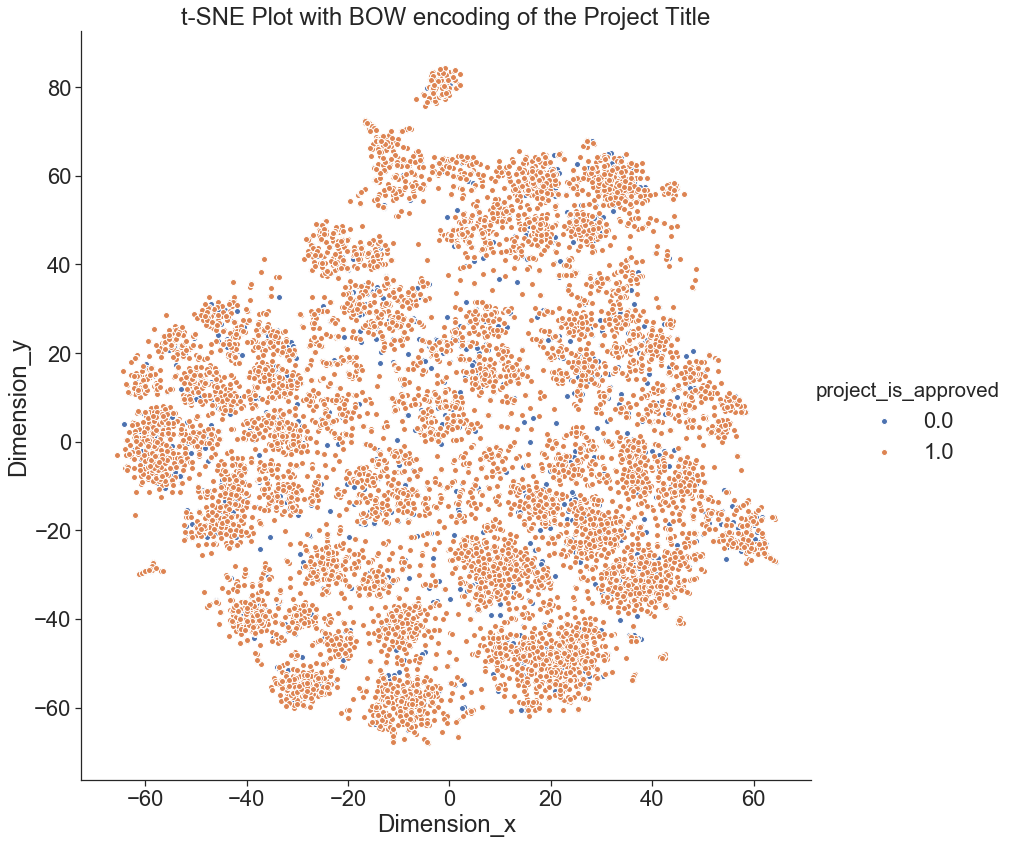

In [59]:
# plotting the result of t-SNE

sns.set(style = "ticks", font_scale = 2)
sns.FacetGrid(tsne_df, hue = 'project_is_approved', height = 12).map(
              plt.scatter, "Dimension_x", "Dimension_y", edgecolor="w").add_legend()
plt.title("t-SNE Plot with BOW encoding of the Project Title")
plt.show()

### 2.2 TSNE with TFIDF encoding of 'project_title' feature

In [52]:
from sklearn.manifold import TSNE

x = X_TFIDF
y = np.array(data['project_is_approved'])

method = TSNE(n_components = 2, perplexity = 30, learning_rate = 200, random_state = 24)

X_embedding = method.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) 
#.toarray() will convert the sparse matrix into dense matrix

# creating a new dataframe 
tsne_data = np.hstack((X_embedding, y.reshape(-1,1)))
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dimension_x", "Dimension_y", "project_is_approved"))

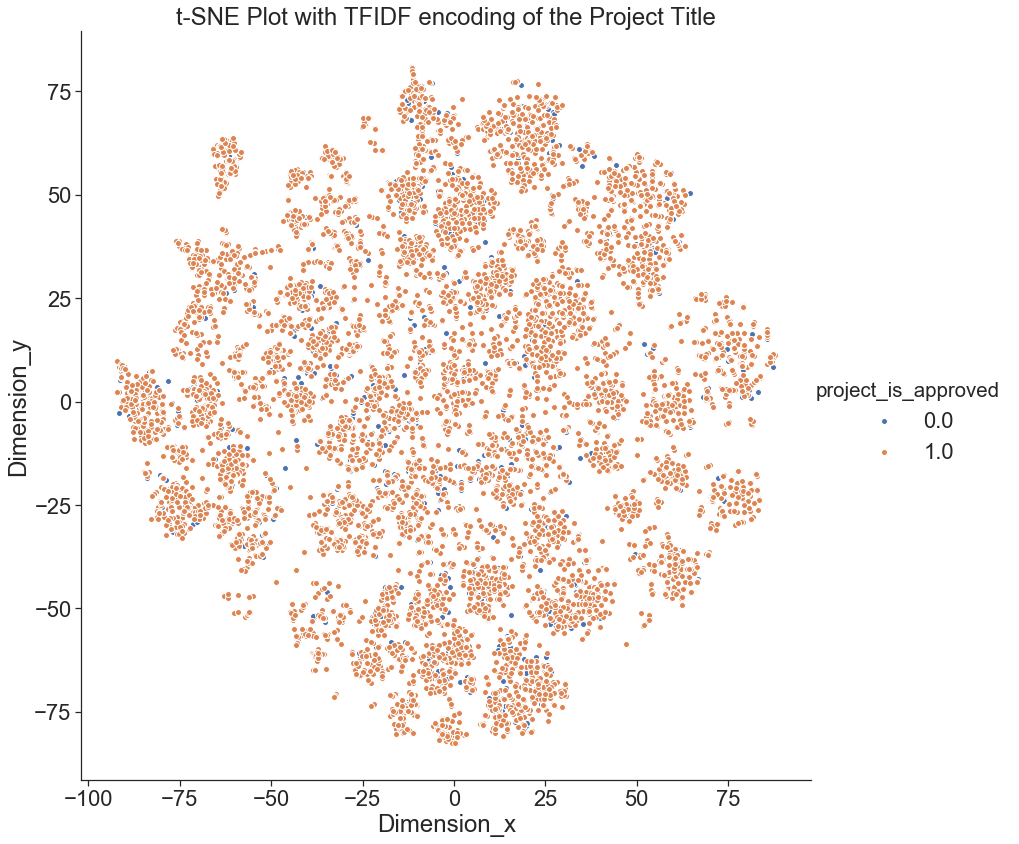

In [55]:
# plotting the result of t-SNE
sns.set(style = "ticks", font_scale = 2)
sns.FacetGrid(tsne_df, hue = 'project_is_approved', height = 12).map(
              plt.scatter, "Dimension_x", "Dimension_y", edgecolor="w").add_legend()
plt.title("t-SNE Plot with TFIDF encoding of the Project Title")
plt.show()

### 2.3 TSNE with AVGW2V encoding of 'project_title' feature

In [82]:
x = x_avgw2v
y = np.array(data['project_is_approved'])

method = TSNE(n_components = 2, perplexity = 100, learning_rate = 400, random_state = 24)

X_embedding = method.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) 
#.toarray() will convert the sparse matrix into dense matrix

# creating a new dataframe 
tsne_data = np.hstack((X_embedding, y.reshape(-1,1)))
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dimension_x", "Dimension_y", "project_is_approved"))

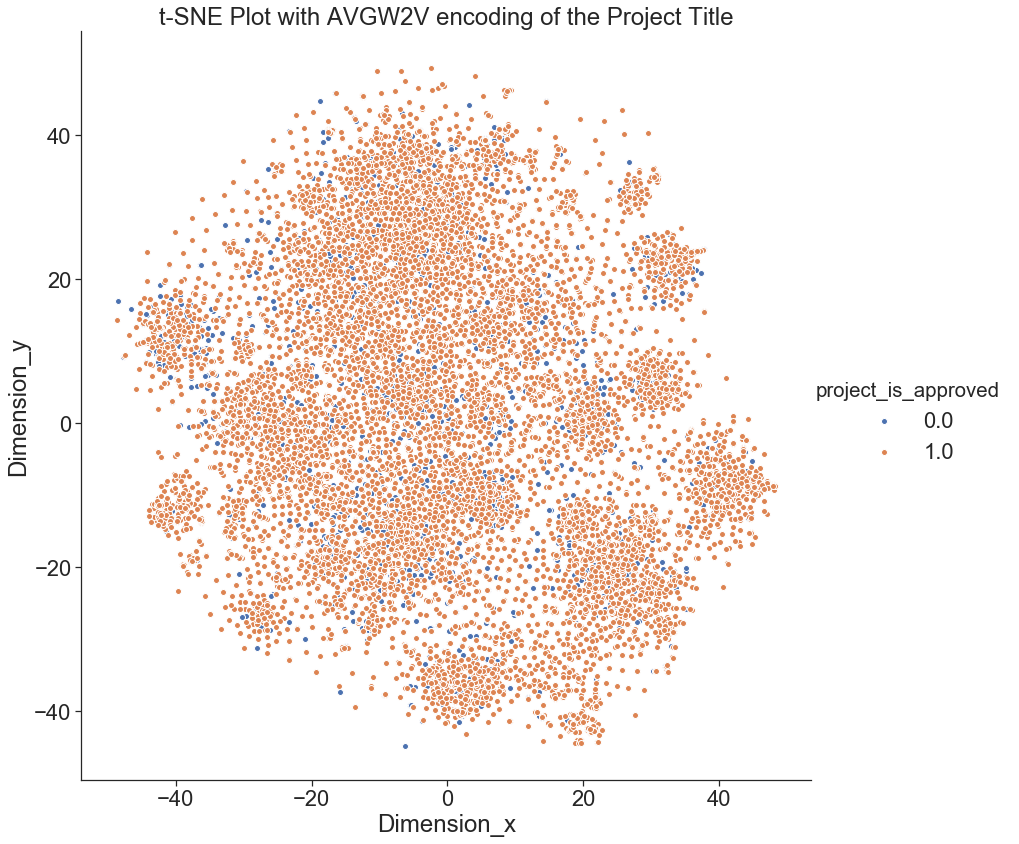

In [84]:
# plotting the result of t-SNE
sns.set(style = "ticks", font_scale = 2)
sns.FacetGrid(tsne_df, hue = 'project_is_approved', height = 12).map(
              plt.scatter, "Dimension_x", "Dimension_y", edgecolor="w").add_legend()
plt.title("t-SNE Plot with AVGW2V encoding of the Project Title")
plt.show()

### 2.4 TSNE with TFIDF-AVGW2V encoding of 'project_title' feature

In [86]:
x = x_tfidfavgw2v
y = np.array(data['project_is_approved'])

method = TSNE(n_components = 2, perplexity = 30, learning_rate = 300, n_iter = 5000, random_state = 24)

X_embedding = method.fit_transform(x.toarray())
#.toarray() will convert the sparse matrix into dense matrix

# creating a new dataframe 
tsne_data = np.hstack((X_embedding, y.reshape(-1,1)))
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dimension_x", "Dimension_y", "project_is_approved"))

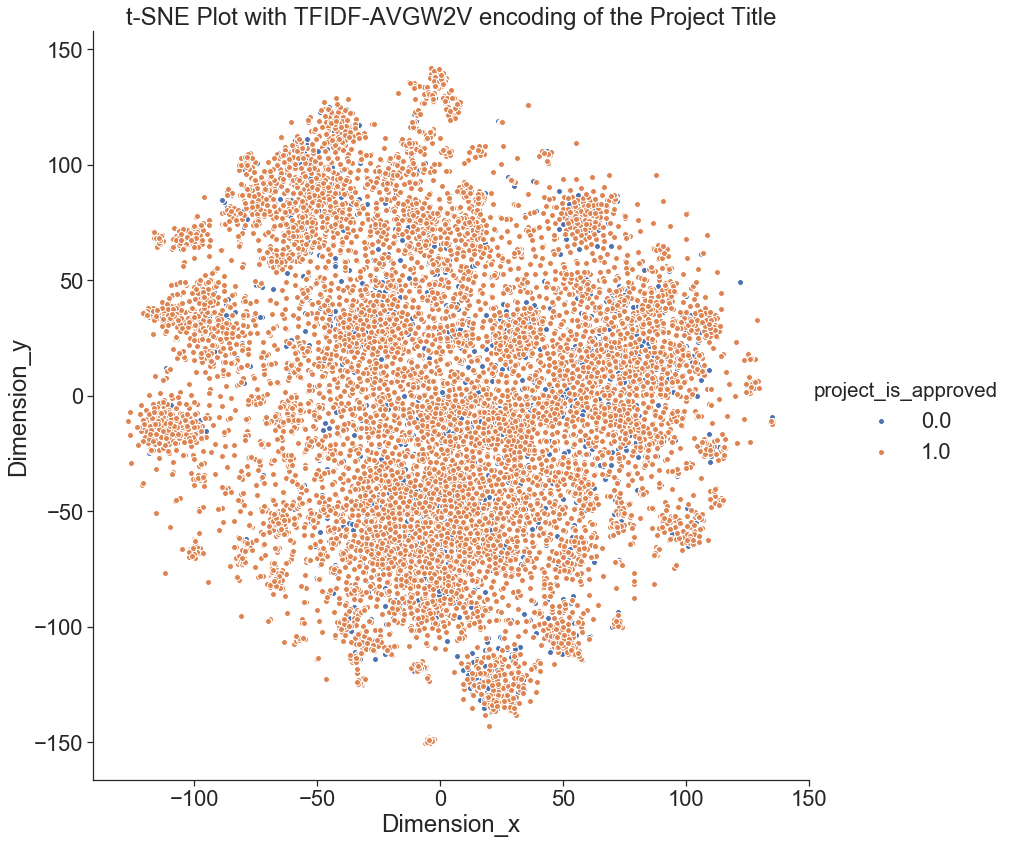

In [87]:
# plotting the result of t-SNE
sns.set(style = "ticks", font_scale = 2)
sns.FacetGrid(tsne_df, hue = 'project_is_approved', height = 12).map(
              plt.scatter, "Dimension_x", "Dimension_y", edgecolor="w").add_legend()
plt.title("t-SNE Plot with TFIDF-AVGW2V encoding of the Project Title")
plt.show()

## BONUS PLOTS 

### 2.5 TSNE with AVGW2V encoding of 'project_title' and 'project_resource_summary' features

In [76]:
x = X_AVGW2V
y = np.array(data['project_is_approved'])

method = TSNE(n_components = 2, perplexity = 30, learning_rate = 200, random_state = 24)

X_embedding = method.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) 
#.toarray() will convert the sparse matrix into dense matrix

# creating a new dataframe 
tsne_data = np.hstack((X_embedding, y.reshape(-1,1)))
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dimension_1", "Dimension_2", "project_is_approved"))

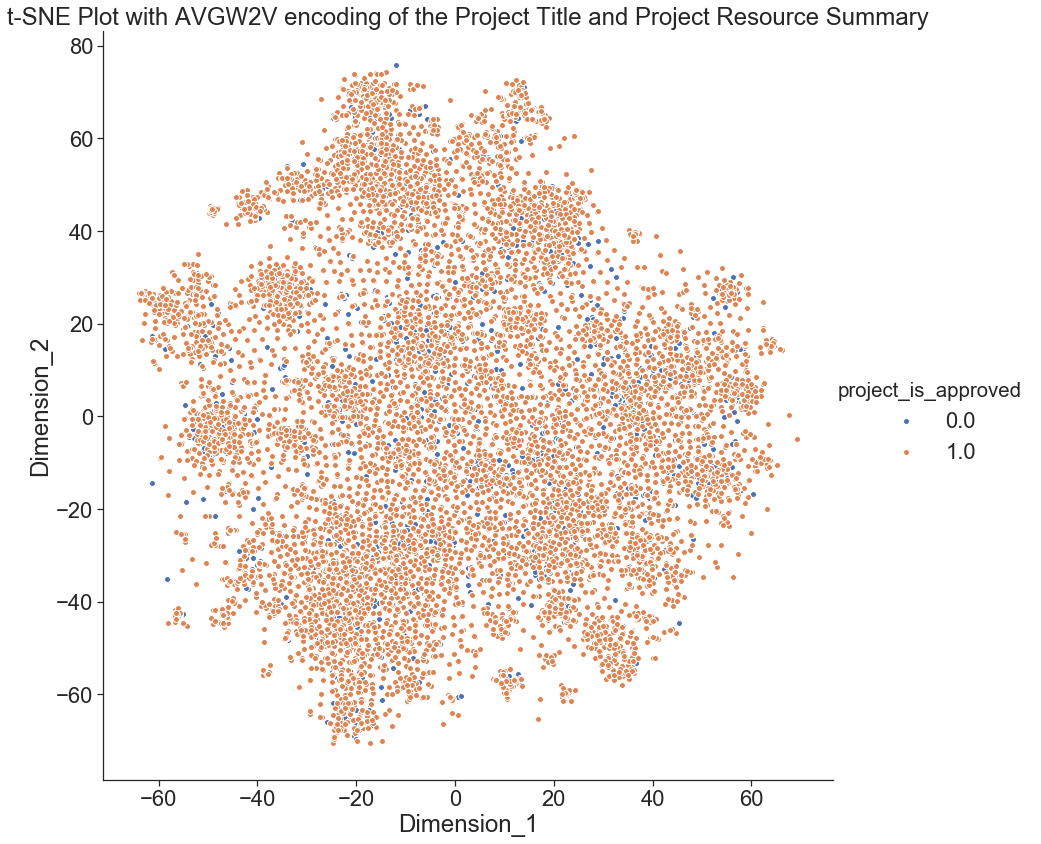

In [78]:
# plotting the result of t-SNE
sns.set(style = "ticks", font_scale = 2)
sns.FacetGrid(tsne_df, hue = 'project_is_approved', height = 12).map(
              plt.scatter, "Dimension_1", "Dimension_2", edgecolor="w").add_legend()
plt.title("t-SNE Plot with AVGW2V encoding of the Project Title and Project Resource Summary")
plt.show()

### 2.6 TSNE with TFIDF-AVGW2V encoding of 'project_title' and 'project_resource_summary' features

In [89]:
x = X_TFIDFW2V
y = np.array(data['project_is_approved'])

method = TSNE(n_components = 2, perplexity = 50, learning_rate = 200, n_iter = 5000, random_state = 24)

X_embedding = method.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) 
#.toarray() will convert the sparse matrix into dense matrix

# creating a new dataframe 
tsne_data = np.hstack((X_embedding, y.reshape(-1,1)))
tsne_df = pd.DataFrame(data = tsne_data, columns = ("Dimension_1", "Dimension_2", "project_is_approved"))

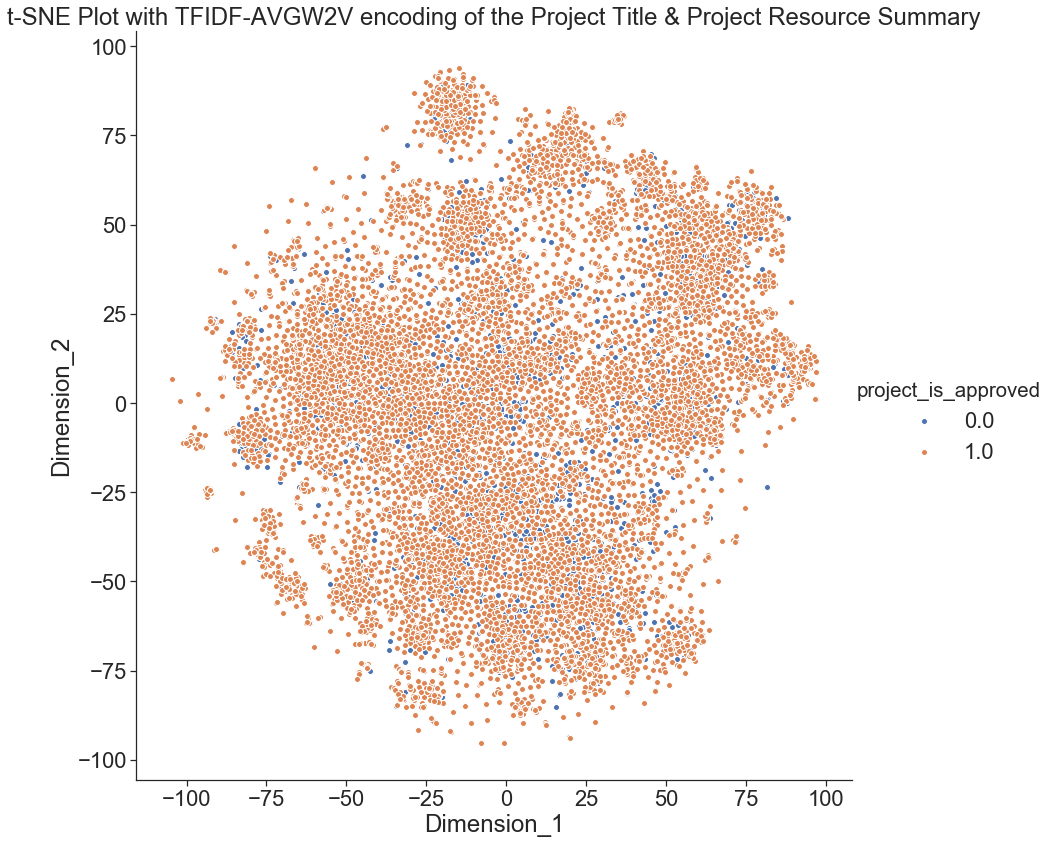

In [92]:
# plotting the result of t-SNE
sns.set(style = "ticks", font_scale = 2)
sns.FacetGrid(tsne_df, hue = 'project_is_approved', height = 12).map(
              plt.scatter, "Dimension_1", "Dimension_2", edgecolor="w").add_legend()
plt.title("t-SNE Plot with TFIDF-AVGW2V encoding of the Project Title & Project Resource Summary")
plt.show()

### 2.7 Summary

* t-SNE technique was applied on 12k data points randomly sampled from the original dataset of 109k datapoints such that ratio of the class labels remains the same. There is a high imbalance in the data, the approved projects are 6 times higher than the rejected projects. 


* The following 10 features were taken into considered for this analysis -> Categorical ('teacher_prefix', 'school_state', 'project_grade_category', 'clean_categories', 'clean_subcategories') | Text ('project_title', 'project_resource_summary') | Numerical ('teacher_number_of_previously_posted_projects', 'price', 'quantity'). 


* Parameter tweaking: 

    
    * Perplexity : 30, 50 and 100. It was observed that, as the perplexity increases the initial data clustering found at lower perplexity value diverges further. Thus, we shouldn't form a conclusion based on a single perplexity value as the clustering seen at low perplexity values could be misleading. 
    
    
    * Step size : 1000 and 5000. With increment in the step size, the shape keeps getting robust. 
   

* We applied t-SNE with BOW, TF-IDF, AVGW2V, TFIDF-W2V encoding of the Project Title feature and also included 2 additional plots with AVGW2V, TFIDF-W2V encoding of Project Title and Project Resource Summary features. 


    * It was observed that there are multiples of small cluster of datapoint but most of the approved project and rejected project datapoints overlapped and there was no visible seperation (even with paraemeter tweaking). 
    
    
    * It can be conclude that most of the words used in project title are same for both approved projects and rejected projects. We need to see if including additional features like Essay text could produce the desired seperation.
    
    
    * As far as the rest of the categorical & numerical features are concerned, as we saw in the Univariate analysis, indivisually couldn't prove as the deciding factor in segregating the class labels. 


#### Although, this analysis was for donorschoose.org, from the Teacher's perpective the following can be done improves the chances of project proposal getting accepted based on the observations from the Univariate exploratory analysis (section 1) : 

* Using Prefix Mr. Mrs. or Ms. instead of 'Teacher'. 


* Project categories and sub-categories like 'Warmth', 'Care', 'Hunger', 'Literacy', 'Literacy-Language' have comparatively high project acceptance rate.


* Including a number in the Project Resource Summary improves the chances of getting project accepted by 6%. Also, limiting project resource summary to around 20 words would further improve the chances. 


* If the project proposals get rejected the first time, lowering price improves the chances of the project proposal getting accepted. 


* If the number of previously submitted project proposals are more than 250, then the likelihood of the current project proposal getting accepted is very high. 

***